In [1]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
from torch import optim
import random
from torchvision import models
import torch.multiprocessing as mp
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import copy
from torch.utils.data import DataLoader, Dataset

In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_df = pd.read_csv("/content/drive/MyDrive/Kaggle_ML/OSIC/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Kaggle_ML/OSIC/test.csv")

# Data Processing

In [4]:
#get the base_line for Weeks
train_df['Weeks_base']=train_df.groupby(['Patient'])['Weeks'].transform('min')
#train_df

In [5]:
df_base=train_df[train_df.Weeks==train_df.Weeks_base].rename(columns={'FVC': 'FVC_base','Percent': 'Percent_base'})
df_base.drop_duplicates(subset=['Patient', 'Weeks'], keep='first',inplace=True)
#df_base

In [6]:
train_df=train_df.merge(df_base[['Patient','FVC_base','Percent_base']],on='Patient',how='left')
train_df['Week_duration'] = train_df['Weeks'] - train_df['Weeks_base']
train_df

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Weeks_base,FVC_base,Percent_base,Week_duration
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,-4,2315,58.253649,0
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,-4,2315,58.253649,9
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,-4,2315,58.253649,11
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,-4,2315,58.253649,13
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,-4,2315,58.253649,15
...,...,...,...,...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked,0,2925,71.824968,13
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked,0,2925,71.824968,19
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked,0,2925,71.824968,31
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked,0,2925,71.824968,43


In [7]:
#One-Hot encode for category features:sex and smokingstatus
features = ['Sex','SmokingStatus']
for feat in features:
    for i in train_df[feat].unique():
        train_df[i] = (train_df[feat] == i).astype(int)
    train_df.drop(feat,axis=1,inplace=True)

In [8]:
train_df

,Patient,Weeks,FVC,Percent,Age,Weeks_base,FVC_base,Percent_base,Week_duration,Male,Female,Ex-smoker,Never smoked,Currently smokes
0,ID00007637202177411956430,-4,2315,58.253649,79,-4,2315,58.253649,0,1,0,1,0,0
1,ID00007637202177411956430,5,2214,55.712129,79,-4,2315,58.253649,9,1,0,1,0,0
2,ID00007637202177411956430,7,2061,51.862104,79,-4,2315,58.253649,11,1,0,1,0,0
3,ID00007637202177411956430,9,2144,53.950679,79,-4,2315,58.253649,13,1,0,1,0,0
4,ID00007637202177411956430,11,2069,52.063412,79,-4,2315,58.253649,15,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,0,2925,71.824968,13,1,0,0,1,0
1545,ID00426637202313170790466,19,2978,73.126412,73,0,2925,71.824968,19,1,0,0,1,0
1546,ID00426637202313170790466,31,2908,71.407524,73,0,2925,71.824968,31,1,0,0,1,0
1547,ID00426637202313170790466,43,2975,73.052745,73,0,2925,71.824968,43,1,0,0,1,0


In [9]:
from sklearn import preprocessing
ro=preprocessing.RobustScaler()
df_new=train_df.columns.difference(['Patient','FVC','Percent','Weeks','Weeks_base'])
X=ro.fit_transform(train_df[df_new])
train_df[df_new]=X

In [10]:
train_df

,Patient,Weeks,FVC,Percent,Age,Weeks_base,FVC_base,Percent_base,Week_duration,Male,Female,Ex-smoker,Never smoked,Currently smokes
0,ID00007637202177411956430,-4,2315,58.253649,1.222222,-4,-0.409316,-0.835497,-0.391304,0.0,0.0,0.0,0.0,0.0
1,ID00007637202177411956430,5,2214,55.712129,1.222222,-4,-0.409316,-0.835497,0.000000,0.0,0.0,0.0,0.0,0.0
2,ID00007637202177411956430,7,2061,51.862104,1.222222,-4,-0.409316,-0.835497,0.086957,0.0,0.0,0.0,0.0,0.0
3,ID00007637202177411956430,9,2144,53.950679,1.222222,-4,-0.409316,-0.835497,0.173913,0.0,0.0,0.0,0.0,0.0
4,ID00007637202177411956430,11,2069,52.063412,1.222222,-4,-0.409316,-0.835497,0.260870,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,0.555556,0,0.195243,-0.287427,0.173913,0.0,0.0,-1.0,1.0,0.0
1545,ID00426637202313170790466,19,2978,73.126412,0.555556,0,0.195243,-0.287427,0.434783,0.0,0.0,-1.0,1.0,0.0
1546,ID00426637202313170790466,31,2908,71.407524,0.555556,0,0.195243,-0.287427,0.956522,0.0,0.0,-1.0,1.0,0.0
1547,ID00426637202313170790466,43,2975,73.052745,0.555556,0,0.195243,-0.287427,1.478261,0.0,0.0,-1.0,1.0,0.0


In [11]:
class OSIC_Data(Dataset):
    
    def __init__(self,patient_ids,df):
        self.df=df[df.Patient.isin(patient_ids)]
        self.data=self.df[self.df.columns.difference(['FVC','Patient','Percent'])].values
        self.patients=self.df['Patient'].values
        self.fvc=self.df['FVC'].values

        
    def __len__(self):
        
        return len(self.df)

    def __getitem__(self, idx):
        
        data = {'fvc': self.fvc[idx],
                'data': self.data[idx]}
        return data

In [12]:
batch_size=64
num_workers=2
ids=train_df.Patient.unique()
random.shuffle(ids)
ids=np.array(ids)
#print(ids)
#spliiting data and loader the data
train_ids,val_ids=np.split(ids, [int(round(0.8 * len(ids), 0))])

train_dataset = OSIC_Data(train_ids,train_df)  
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=num_workers)
val_dataset = OSIC_Data(val_ids,train_df)  
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True,num_workers=num_workers)

In [13]:
class NN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.fc1 = nn.Linear(input_dim, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, output_dim)
        self.sigma = nn.Linear(100, output_dim)

    def forward(self, x):
        out=x
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        fc3 = F.relu(self.fc3(out))
        sigma = F.relu(self.sigma(out))
        return fc3,sigma

In [14]:
def calcualte_metric_loss(pred_y,true_y,pred_sigma):
        true_y=torch.reshape(true_y,pred_y.shape)
        sigma_clipped=torch.clamp(pred_sigma,min=70)
        delta=torch.clamp(torch.abs(pred_y-true_y),max=1000)
        metric=torch.div(-torch.sqrt(torch.tensor([2.0]))*delta,sigma_clipped)-torch.log(torch.sqrt(torch.tensor([2.0]))*sigma_clipped)
        return -metric
    
def calculate_target_loss(pred_y,true_y):
    true_y=torch.reshape(true_y,pred_y.shape)
    error=torch.abs(pred_y-true_y)
    return error

In [15]:
input_dim=train_dataset.data.shape[1]
output_dim=1
epochs=200

In [16]:
model=  NN(input_dim, output_dim)
optimizer = optim.Adam(model.parameters())

In [19]:
epoch_train_loss=[]
epoch_val_loss=[]
epoch_train_metric=[]
epoch_val_metric=[]
for i in range(epochs):
    print("epoch:",i)
    train_loss=0
    train_metric=0
    model.train()
    for batch_idx, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        fvc,sigma = model(data['data'].float())
        fvc_loss =  calculate_target_loss(fvc,data['fvc']).mean()
        metric_loss = calcualte_metric_loss(fvc,data['fvc'],sigma).mean()
        loss=fvc_loss
        loss.backward()
        train_loss += loss.item()
        train_metric += metric_loss.item()
        optimizer.step()

    val_loss=0
    val_metric=0
    model.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(val_dataloader):
            fvc,sigma = model(data['data'].float())
            fvc_loss = calculate_target_loss(fvc,data['fvc']).mean()
            metric_loss =calcualte_metric_loss(fvc,data['fvc'],sigma).mean()
            loss=fvc_loss
            val_loss += loss.item()
            val_metric += metric_loss.item()
        print('Average validation loss FVC: {:.4f}'.format(val_loss / len(val_dataloader)))
        print('Average validation metric: {:.4f}'.format(val_metric / len(val_dataloader)))

    epoch_train_loss.append(train_loss/ len(train_dataloader))
    epoch_val_loss.append(val_loss / len(val_dataloader))
    epoch_train_metric.append(train_metric/ len(train_dataloader))
    epoch_val_metric.append(val_metric / len(val_dataloader))

epoch: 0
Average validation loss FVC: 2614.3223
Average validation metric: 24.7862
epoch: 1
Average validation loss FVC: 2555.4905
Average validation metric: 24.7737
epoch: 2
Average validation loss FVC: 2423.9326
Average validation metric: 24.7423
epoch: 3
Average validation loss FVC: 2161.9584
Average validation metric: 24.1345
epoch: 4
Average validation loss FVC: 1758.0730
Average validation metric: 22.3873
epoch: 5
Average validation loss FVC: 1505.8463
Average validation metric: 21.3665
epoch: 6
Average validation loss FVC: 1478.0077
Average validation metric: 20.8366
epoch: 7
Average validation loss FVC: 1464.4685
Average validation metric: 20.8622
epoch: 8
Average validation loss FVC: 1449.7204
Average validation metric: 20.8524
epoch: 9
Average validation loss FVC: 1444.3035
Average validation metric: 20.8900
epoch: 10
Average validation loss FVC: 1424.7325
Average validation metric: 20.8517
epoch: 11
Average validation loss FVC: 1405.7040
Average validation metric: 20.7343
ep

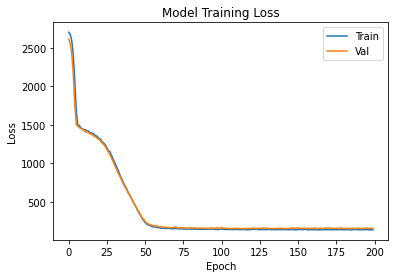

In [20]:
plt.figure()
plt.plot(epoch_train_loss, label='Train')
plt.plot(epoch_val_loss, label='Val')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

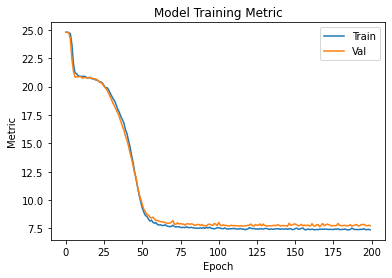

In [21]:
plt.figure()
plt.plot(epoch_train_metric, label='Train')
plt.plot(epoch_val_metric, label='Val')
plt.title('Model Training Metric')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()